In [4]:
import pandas as pd
import numpy as np
import torch
from data_reader import read_interaction_matrix
R = read_interaction_matrix()
from tqdm import tqdm

n_users, n_items = R.shape
n_latent = 64
r = 0.001

# learning rate
INIT_LR = 0.05
END_LR = 0.0001
n_epochs = 750

# error check steps
erc_step = 100
# min error threshold
eth = 1e-4

rng = np.random.default_rng(seed=1234)
scale = 1./n_latent
Q0 = rng.normal(scale=scale, size=(n_users, n_latent))
P0 = rng.normal(scale=scale, size=(n_items, n_latent))

def E(R, P, Q):
    return np.abs(R - Q@P.T).sum() + r*((Q*Q).sum() + (P*P).sum())

def LR(epoch, warmup):
    s = warmup / n_epochs
    x = (epoch - n_epochs)/n_epochs
    
    if epoch >= warmup:
        x = x - s
        y = ((1 + x))
        
        # y = (n_epochs*(s-1) + 1/(1 - s))*x + n_epochs*(1-s)
        # y = y * n_epochs / (n_epochs - s*n_epochs)
    else:
        x += 1
        y = (-2./s)*(x**2) + 2*s
        
    # f = lambda e : ((e/n_epochs)) * (((e/5 + (1-stop_warmup)*n_epochs)/n_epochs)**5)
    # y = f(2/3*n_epochs + (-n_epochs + epoch)*3.)
    # if epoch < stop_warmup:
    #     x *= ((-epoch + stop_warmup//2)*3/n_epochs)**3
    #     if epoch % 20 == 0:
    #         print("warmup")
    # z = lambda x : (x - 1/3)**(0.3) * np.exp(-x**(0.8))
    
    lr = INIT_LR - (INIT_LR-END_LR) * y
    return lr


9it [00:00, 43.50it/s]

err: 2.30e+04, lr: 0.0065000, batch: 2000


98it [00:02, 57.31it/s]

err: 1.30e+04, lr: 0.0164783, batch: 500


201it [00:37,  2.89it/s]

err: 1.30e+04, lr: 0.0135261, batch: 300


301it [01:07,  3.18it/s]

err: 1.23e+04, lr: 0.0113332, batch: 100


402it [01:34, 13.56it/s]

err: 1.12e+04, lr: 0.0097043, batch: 50


502it [01:41, 12.80it/s]

err: 9.58e+03, lr: 0.0084944, batch: 25


602it [01:49, 11.81it/s]

err: 7.81e+03, lr: 0.0075956, batch: 15


701it [01:59, 10.72it/s]

err: 6.24e+03, lr: 0.0069280, batch: 10


801it [02:16,  4.56it/s]

err: 3.20e+03, lr: 0.0064321, batch: 4


901it [02:38,  3.79it/s]

err: 2.20e+03, lr: 0.0060638, batch: 2


1001it [03:26,  1.80it/s]

err: 1.99e+02, lr: 0.0057902, batch: 1


1020it [03:37,  4.70it/s]


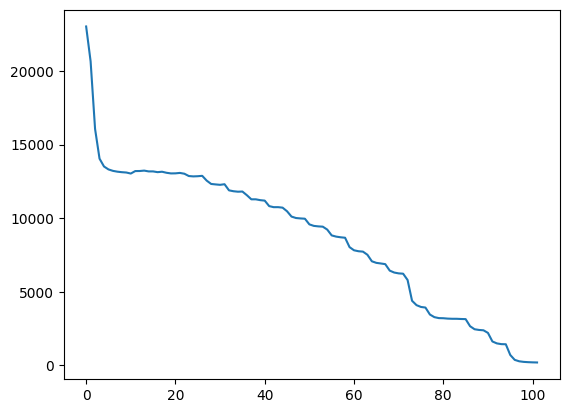

In [1]:
from data_reader import read_interaction_matrix
R = read_interaction_matrix()

from mf import matrix_factorization
from matplotlib import pyplot as plt

def get_errors(logs):
    errors = [log[0] for log in logs]
    return errors

q, p, err, logs = matrix_factorization(R, lr=(2e-2, 5e-3), n_epochs=1020, reg=0.001, n_latent=64, log_step=10)
errors = get_errors(logs)
plt.plot(errors)

In [2]:
import numpy as np
S = (q @ p.T)
S.sum(), R.sum()

(101924.41788753596, 23038.0)

In [4]:
logs[200][1], logs[100][1]

IndexError: list index out of range

In [3]:
S[R.nonzero()]

array([1.00325206, 1.01278561, 1.00248923, ..., 0.99574944, 0.99619719,
       1.05071509])

In [5]:
from mf import error

print(error(R, q, p, 0.001))

185.83854290118632


In [12]:
S = (q@p.T)

def frmt(f):
    i = 5
    i += 1 if f < 0 else 0
    return str(f)[:i]

def describe(M):
    return f'mean: {frmt(M.mean())}, min: {frmt(M.min())}, max: {frmt(M.max())}'

describe(S)

'mean: 0.103, min: -1.138, max: 1.428'

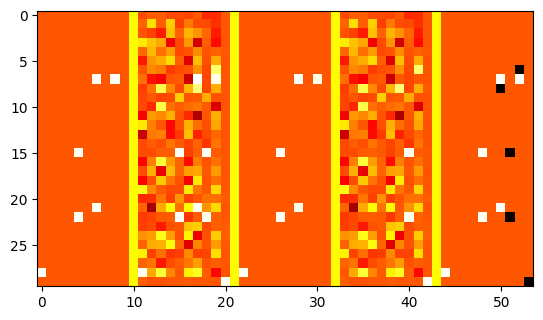

In [54]:
from mf import heatmap
FP = np.zeros_like(S)
FP[S > S.max() * 0.5] = -1
FP[R.nonzero()] = 1

P = S * R
Z = S - (S * R)

D = np.zeros((P.shape[0], 1))
D[:,0] = 0.5

t = tuple(M[0:30, 0:min(10, M.shape[1])] for M in (R, D, S, D, P, D, Z, D, FP))
V = np.concatenate(t, axis=1)
heatmap(V)

In [44]:
V - V.min()

array([[1.13821742, 1.13821742, 1.13821742, ..., 1.14286188, 1.04048144,
        1.13418668],
       [1.13821742, 1.13821742, 1.13821742, ..., 1.09039014, 1.10019642,
        1.05459227],
       [1.13821742, 1.13821742, 1.13821742, ..., 0.94773432, 1.17630989,
        1.24039073],
       ...,
       [1.13821742, 1.13821742, 1.13821742, ..., 1.01200108, 1.11326779,
        1.08002204],
       [1.13821742, 1.13821742, 1.13821742, ..., 1.52526531, 1.16479716,
        1.01306436],
       [1.13821742, 1.13821742, 1.13821742, ..., 1.31523295, 1.07849042,
        1.12636972]])

In [29]:
len(t)

4

In [27]:
t[3]

array([[-0.        ,  0.        ,  0.        , -0.        , -0.        ,
        -0.        , -0.        , -0.        , -0.        , -0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.        ,
         0.        , -0.        , -0.        , -0.        ,  0.        ],
       [-0.        , -0.        , -0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        , -0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -0.        , -0.        ,
         0.        , -0.        ,  0.        , -0.        , -0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.        ,
        -0.        ,  0.        , -0.        ,  0.        ,  0.        ],
       [-0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.        ,  0.        , -0.        ,  0.        , -0.        ],
       [-0.        ,  0.        ,  0.        , -0.        , -0.        ,
        -0.        ,  0.        , -0.        

In [11]:
S[R.nonzero()].max(), (S - S * R).max()

(0.7773755765474227, -1.1382174152854598)

In [4]:
from mf import init_pq

q, p = init_pq(*R.shape, 64)